In [1]:
# Libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import copy as cp
import importlib

import self_defined_functions as ft

In [2]:
transCnt_dict = ft.get_trCnt()

In [3]:
importlib.reload( ft )
ft.gen_ANOVA_xlsx()

In [18]:
obser = []
startDate = dt.datetime( 2015, 3, 1 )
for i in range( 30 ) : 
    obser.append( startDate ) 
    startDate += dt.timedelta( days = 1 )

In [19]:
cnt = []
for i in obser : 
    cnt.append( transCnt_dict[i] )

Text(0.5, 0, 'fd')

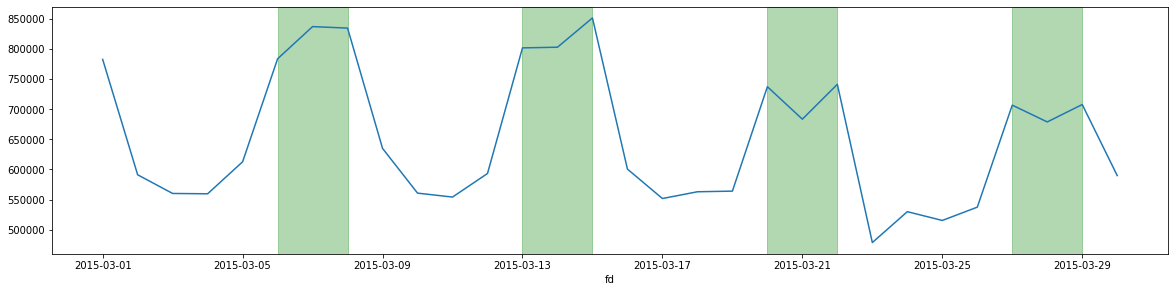

In [25]:
fig = plt.figure( figsize = ( 20, 10 ) ) 
ax = fig.add_subplot( 2, 1, 1 ) 
ax.plot( obser, cnt )
# ax.ylim( 0, 850000 )

start = None 
end = None 
for i in obser : 
    if i.weekday() == 4 :
        start = i
    elif i.weekday() == 6 and start != None : 
        end = i  
    if start != None and end != None : 
        ax.axvspan( start, end, color="green", alpha=0.3)
        start = None 
        end = None 

plt.xlabel( '日期', fontsize = 15 )
plt.ylabel( '人次', fontsize = 15 )

In [8]:
obserYear = 2008
avg = []
currentTime = dt.datetime( obserYear, 1, 1 )
currentMonth = currentTime.month
while currentTime.year < obserYear + 1 : 
    total = 0 
    leng = 0 
    while currentTime.month == currentMonth :
        total += transCnt_dict[currentTime]
        leng += 1 
        currentTime += dt.timedelta( days = 1 )
    currentMonth += 1
    avg.append( total / leng )
avg.append( total / leng ) 
    

(0.0, 2000000.0)

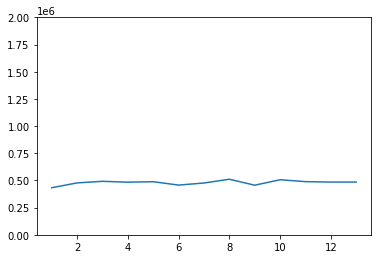

In [9]:
plt.plot( range( 1, 14 ), avg )
plt.ylim( ( 0, 2000000 ) )

# 2Way ANOVA of different holiday

In [10]:
ANOVA_df

NameError: name 'ANOVA_df' is not defined

In [ ]:
ANOVA_df.drop(ANOVA_df[(ANOVA_df['weekday'] >= 4)].index, inplace=True)

In [ ]:
ANOVA_df_before2020 = ANOVA_df[np.array( ANOVA_df['year'] < 2020 )]
ANOVA_df_2005_2010 = ANOVA_df[np.array( ANOVA_df['year'] < 2011 )]
ANOVA_df_before2020_noTy = ANOVA_df_before2020[ANOVA_df_before2020['is_typhoon'] == False]
ANOVA_df_before2020_noTy_noNYE = ANOVA_df_before2020_noTy[ANOVA_df_before2020_noTy['is_CNYE'] == False]
ANOVA_df_before2020_noTy_noNYE = ANOVA_df_before2020_noTy_noNYE[ANOVA_df_before2020_noTy_noNYE['is_NYE'] == False]

In [ ]:
ANOVA_df_before2020_noTy

,date,year,month,weekday,day,trans_cnt,is_typhoon,day_type,holi_type,holi_len,is_CNYE,is_NYE
2,2005-01-03,2005,1,0,3,596282,False,weekday,weekday,0,False,False
3,2005-01-04,2005,1,1,4,504102,False,weekday,weekday,0,False,False
4,2005-01-05,2005,1,2,5,526798,False,weekday,weekday,0,False,False
5,2005-01-06,2005,1,3,6,560930,False,weekday,weekday,0,False,False
9,2005-01-10,2005,1,0,10,615202,False,weekday,weekday,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5470,2019-12-24,2019,12,1,24,1238222,False,weekday,weekday,0,False,False
5471,2019-12-25,2019,12,2,25,1279910,False,weekday,weekday,0,False,False
5472,2019-12-26,2019,12,3,26,1237004,False,weekday,weekday,0,False,False
5476,2019-12-30,2019,12,0,30,1250386,False,weekday,weekday,0,False,False


In [ ]:
results1 = smf.ols('trans_cnt ~ C(day_type)', data=ANOVA_df_before2020_noTy_noNYE).fit()
aov_14106_two = sms.anova_lm( results1, typ=2 )

aov_14106_two

,sum_sq,df,F,PR(>F)
C(day_type),9.416839e+12,2.0,147.447439,8.843391e-62
Residual,9.487255e+13,2971.0,NaN,NaN


In [ ]:
# results1 = smf.ols('trans_cnt~ C(day_type)', data=ANOVA_df_before2020_noTy_noNYE).fit()
# aov_table

In [ ]:
stat1, p1 = stats.shapiro( results1.resid )
print( f'p = {p1}' )

p = 1.921965563351093e-23


In [ ]:
len( results1.resid )

2974

In [ ]:
resid_dict1 = ft.build_dict( ANOVA_df_before2020_noTy_noNYE['date'], results1.resid )

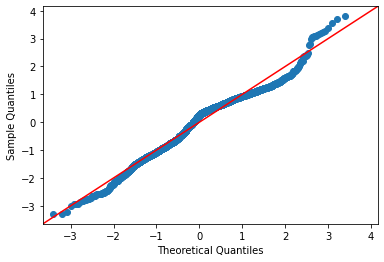

In [ ]:
fig = sm.qqplot( results1.resid, stats.norm, fit=True, line = '45' ) 

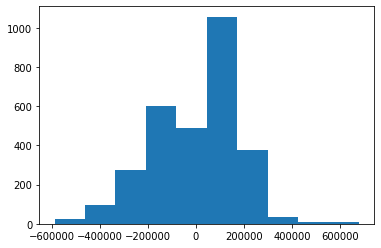

In [ ]:
_ = plt.hist( results1.resid )

In [ ]:
stats.normaltest(results1.resid)

NormaltestResult(statistic=55.98074930129871, pvalue=6.981274954088961e-13)

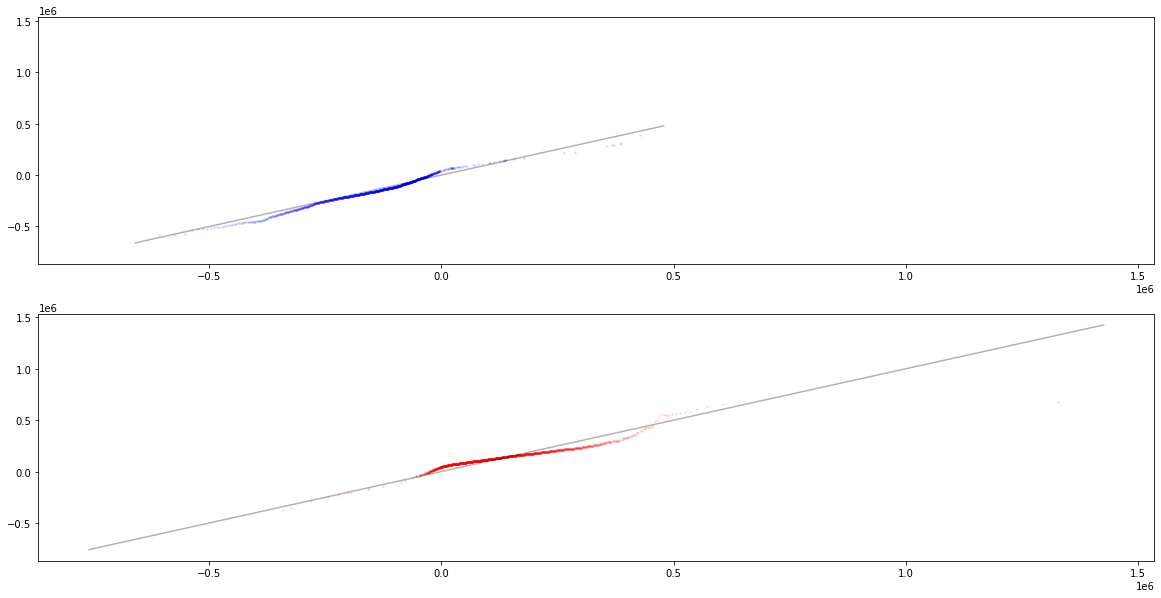

In [ ]:
dif, dates, cnts, theos = ft.self_qqplot( resid_dict1, 2012 )

In [ ]:
sorted( dates[:50] )

[Timestamp('2007-04-04 00:00:00'),
 Timestamp('2008-04-03 00:00:00'),
 Timestamp('2008-10-09 00:00:00'),
 Timestamp('2011-10-10 00:00:00'),
 Timestamp('2012-02-06 00:00:00'),
 Timestamp('2012-08-13 00:00:00'),
 Timestamp('2013-02-27 00:00:00'),
 Timestamp('2013-08-12 00:00:00'),
 Timestamp('2013-08-26 00:00:00'),
 Timestamp('2013-10-09 00:00:00'),
 Timestamp('2014-01-27 00:00:00'),
 Timestamp('2014-01-28 00:00:00'),
 Timestamp('2014-02-05 00:00:00'),
 Timestamp('2014-04-03 00:00:00'),
 Timestamp('2014-07-07 00:00:00'),
 Timestamp('2014-07-14 00:00:00'),
 Timestamp('2014-08-11 00:00:00'),
 Timestamp('2014-08-18 00:00:00'),
 Timestamp('2014-09-09 00:00:00'),
 Timestamp('2015-02-17 00:00:00'),
 Timestamp('2015-03-09 00:00:00'),
 Timestamp('2016-04-06 00:00:00'),
 Timestamp('2016-05-02 00:00:00'),
 Timestamp('2016-12-26 00:00:00'),
 Timestamp('2017-01-19 00:00:00'),
 Timestamp('2017-01-25 00:00:00'),
 Timestamp('2017-01-31 00:00:00'),
 Timestamp('2017-02-07 00:00:00'),
 Timestamp('2017-04-

In [ ]:
cnts[:10], theos[:10]

(array([678699.77036517, 301325.25373134, 301099.77036517, 305842.23728814,
        298893.77036517, 300339.77036517, 287969.77036517, 305727.77036517,
        298729.77036517, 289875.77036517]),
 array([1327281.11036569,  382450.39009945,  380974.03741155,
         385483.96325707,  378097.08393721,  379523.25644882,
         366234.01506012,  383953.33669803,  376694.61103457,
         367474.26200685]))

In [ ]:
dates[:10]

array([Timestamp('2019-09-12 00:00:00'), Timestamp('2018-09-24 00:00:00'),
       Timestamp('2019-12-23 00:00:00'), Timestamp('2019-04-04 00:00:00'),
       Timestamp('2012-02-06 00:00:00'), Timestamp('2016-12-26 00:00:00'),
       Timestamp('2014-09-09 00:00:00'), Timestamp('2008-04-03 00:00:00'),
       Timestamp('2019-04-08 00:00:00'), Timestamp('2007-04-04 00:00:00')],
      dtype=object)

NameError: name 'results2' is not defined

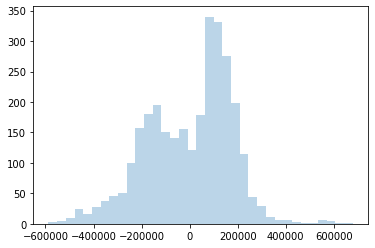

In [ ]:
_ = plt.hist( results1.resid, bins='auto', alpha = 0.3 )
_ = plt.hist( results2.resid, bins='auto', alpha = 0.3 )

In [ ]:
import seaborn as sns

In [ ]:
AFTER_2020 = np.array( YEAR ) > 2020

In [ ]:
sns_df = pd.DataFrame( {'After_2020' : AFTER_2020, 'cnt' : CNT, 'resid':results.resid } )

Text(0, 0.5, 'Value')

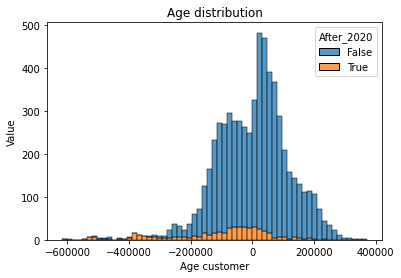

In [ ]:
sns.histplot(data=sns_df, x="resid", hue="After_2020", multiple="stack")
plt.title("Age distribution")
plt.xlabel("Age customer")
plt.ylabel("Value")

# 2 way ANOVA of different length of weekends